In [10]:
import os
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from scipy import stats

load_dotenv()

sql_username = os.getenv('db_username')
sql_password = os.getenv('db_password')
sql_host = os.getenv('db_hostname')
sql_database = os.getenv('db_database')

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"
TABLE = "research_experiment_refactor_test"

engine = create_engine(url_string)

SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Power(W)",
    "distance_total",
    "accel_load_accum",
    "leftMaxForce",
    "rightMaxForce"
]

# 2 athletes 
PLAYER_1 = "PLAYER_982"
PLAYER_2 = "PLAYER_143"

METRICS_TO_PLOT = [
    "Jump Height(m)",
    "distance_total"
]

sns.set(style="whitegrid")


In [ ]:
# function to load time series data for a given player and metrics

def load_player_timeseries(playername, metrics):
    metrics_sql = "(" + ",".join([f"'{m}'" for m in metrics]) + ")"

    query = f"""
        SELECT playername, team, metric, value, timestamp
        FROM {TABLE}
        WHERE playername = '{playername}'
          AND metric IN {metrics_sql}
    """

    df = pd.read_sql(query, engine)
    if df.empty:
        print(f"No data for {playername}")
        return df

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    return df


df_p1 = load_player_timeseries(PLAYER_1, METRICS_TO_PLOT)
df_p2 = load_player_timeseries(PLAYER_2, METRICS_TO_PLOT)

df_p1.head(), df_p2.head()


(   playername                                               team  \
 0  PLAYER_982  Group: 21-22, Team: Stony Brook Men's Basketball    
 1  PLAYER_982  Group: 21-22, Team: Stony Brook Men's Basketball    
 2  PLAYER_982  Group: 21-22, Team: Stony Brook Men's Basketball    
 3  PLAYER_982  Group: 21-22, Team: Stony Brook Men's Basketball    
 4  PLAYER_982  Group: 21-22, Team: Stony Brook Men's Basketball    
 
            metric   value           timestamp  
 0  Jump Height(m)  0.3279 2021-06-24 16:36:46  
 1  Jump Height(m)  0.3408 2021-06-29 15:43:38  
 2  Jump Height(m)  0.3364 2021-07-06 15:40:52  
 3  Jump Height(m)  0.3498 2021-07-16 15:46:21  
 4  Jump Height(m)  0.3479 2021-07-23 15:58:07  ,
    playername                                              team  \
 0  PLAYER_143  Group: Football Bigs, Team: Stony Brook Football   
 1  PLAYER_143  Group: Football Bigs, Team: Stony Brook Football   
 2  PLAYER_143  Group: Football Bigs, Team: Stony Brook Football   
 3  PLAYER_143  G

In [ ]:
# filter to last 12 months

def filter_last_months(df, months=12):
    if df.empty:
        return df
    latest = df["timestamp"].max()
    cutoff = latest - pd.DateOffset(months=months)
    return df[df["timestamp"] >= cutoff]

df_p1 = filter_last_months(df_p1, months=12)
df_p2 = filter_last_months(df_p2, months=12)

df_p1["player"] = PLAYER_1
df_p2["player"] = PLAYER_2

df_both = pd.concat([df_p1, df_p2], ignore_index=True)
df_both.head()


,playername,team,metric,value,timestamp,player
0,PLAYER_982,"Group: 21-22, Team: Stony Brook Men's Basketball",Jump Height(m),0.3279,2021-06-24 16:36:46,PLAYER_982
1,PLAYER_982,"Group: 21-22, Team: Stony Brook Men's Basketball",Jump Height(m),0.3408,2021-06-29 15:43:38,PLAYER_982
2,PLAYER_982,"Group: 21-22, Team: Stony Brook Men's Basketball",Jump Height(m),0.3364,2021-07-06 15:40:52,PLAYER_982
3,PLAYER_982,"Group: 21-22, Team: Stony Brook Men's Basketball",Jump Height(m),0.3498,2021-07-16 15:46:21,PLAYER_982
4,PLAYER_982,"Group: 21-22, Team: Stony Brook Men's Basketball",Jump Height(m),0.3479,2021-07-23 15:58:07,PLAYER_982


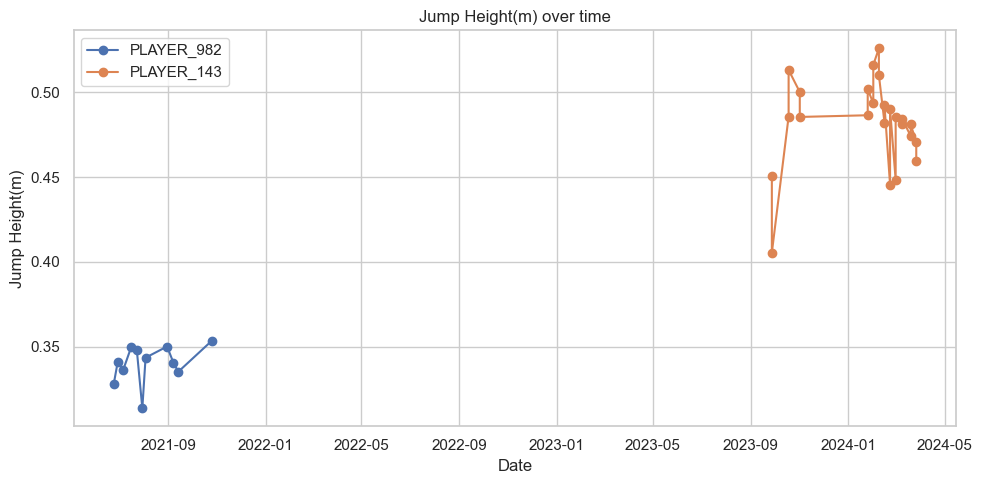

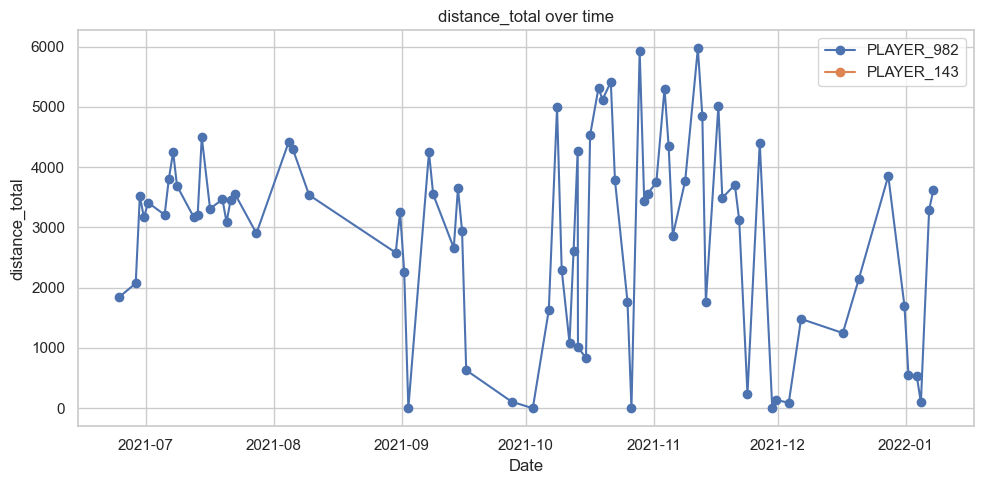

In [ ]:
# plot time series for each metric comparing the two players

for metric in METRICS_TO_PLOT:
    subset = df_both[df_both["metric"] == metric]

    if subset.empty:
        print(f"No data for metric: {metric}")
        continue

    plt.figure(figsize=(10, 5))
    for player in [PLAYER_1, PLAYER_2]:
        s = subset[subset["player"] == player].sort_values("timestamp")
        plt.plot(s["timestamp"], s["value"], marker="o", label=player)

    plt.title(f"{metric} over time")
    plt.xlabel("Date")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# identify best and worst performance for each metric and player

rows = []

for metric in METRICS_TO_PLOT:
    for player in [PLAYER_1, PLAYER_2]:
        s = df_both[(df_both["metric"] == metric) & (df_both["player"] == player)]
        if s.empty:
            continue

        idx_max = s["value"].idxmax()
        idx_min = s["value"].idxmin()

        best_row = s.loc[idx_max]
        worst_row = s.loc[idx_min]

        rows.append({
            "player": player,
            "metric": metric,
            "best_date": best_row["timestamp"],
            "best_value": best_row["value"],
            "worst_date": worst_row["timestamp"],
            "worst_value": worst_row["value"]
        })

best_worst_df = pd.DataFrame(rows)
best_worst_df


,player,metric,best_date,best_value,worst_date,worst_value
0,PLAYER_982,Jump Height(m),2021-10-25 16:11:30,0.353500,2021-07-30 13:32:08,0.3137
1,PLAYER_143,Jump Height(m),2024-02-08 14:57:51,0.525800,2023-09-27 11:29:24,0.4054
2,PLAYER_982,distance_total,2021-11-11 16:03:17,5971.331531,2021-11-29 16:20:53,0.0898


In [ ]:
# identify trends over time using linear regression

trend_rows = []

for metric in METRICS_TO_PLOT:
    for player in [PLAYER_1, PLAYER_2]:
        s = df_both[(df_both["metric"] == metric) & (df_both["player"] == player)]
        if len(s) < 2:
            continue

        s = s.sort_values("timestamp")
        x = s["timestamp"].map(pd.Timestamp.toordinal).values
        y = s["value"].values

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        trend = "increasing" if slope > 0 else "decreasing"
        trend_rows.append({
            "player": player,
            "metric": metric,
            "slope": slope,
            "r": r_value,
            "p_value": p_value,
            "trend": trend
        })

trend_df = pd.DataFrame(trend_rows)
trend_df


,player,metric,slope,r,p_value,trend
0,PLAYER_982,Jump Height(m),0.000112,0.369652,0.263187,increasing
1,PLAYER_143,Jump Height(m),0.000058,0.133623,0.533631,increasing
2,PLAYER_982,distance_total,-5.762949,-0.209977,0.065015,decreasing


# Final Interpretation for Part 3.1

## Data Preparation  
To compare the two athletes fairly, the data was filtered to include only the most recent twelve months for each athlete. After that, both sets were combined into one timeline so their performance patterns could be viewed side by side. This helped highlight how their outputs progressed over the same period rather than looking at each athlete in isolation.

## Line Plot Interpretation  
The jump height results immediately showed a noticeable performance gap. PLAYER_982 stayed within a lower and very steady range, mostly between 0.32 and 0.35 meters, which suggests a consistent but modest jump profile. PLAYER_143, on the other hand, consistently produced higher values, usually between 0.45 and 0.52 meters. This difference aligns with what we typically see in athletes who either have stronger lower-body power or more favorable neuromuscular characteristics for vertical jumping.

For distance_total, only PLAYER_982 had available data, and their values varied from session to session. This is expected for GPS-based external load because running distance depends heavily on daily training demands, coaching emphasis, and session intensity. 

## Best and Worst Performances  
When looking at peak performance dates, PLAYER_982 reached their highest jump height on October 25, 2021, while PLAYER_143 recorded their best on February 8, 2024. These peak values reinforce the difference seen in the line plots, with PLAYER_143 showing a higher overall ceiling. PLAYER_982 also logged the highest distance_total on November 11, 2021, which may have been a conditioning day or a high-intensity practice.

## Trend Analysis  
Both athletes showed slight upward trends in jump height over the twelve-month window, which suggests gradual improvement or effective training adaptations over time. PLAYER_982 showed a downward trend in distance_total as the months progressed, which might reflect changes in training volume, recovery needs, or a shift in practice structure. Nothing about the trends is unusual; in fact, they line up well with what the literature reports about performance metrics responding differently based on the demands of the training cycle.

Overall, the patterns make sense in the context of athlete development. Jump height tends to improve slowly with consistent strength and power training, while external load metrics like distance_total naturally rise and fall depending on how practices are structured week to week.
